In [8]:
import json
import os
from typing import List, Dict
import numpy as np
import networkx as nx
from gtda.homology import VietorisRipsPersistence
import matplotlib.pyplot as plt
from gtda.plotting import plot_diagram


In [9]:
def load_game_data(file_path: str) -> List[Dict]:
    with open(file_path, 'r') as file:
        game_data = json.load(file)
    return game_data

def load_all_games(data_dir: str) -> List[List[Dict]]:
    all_games = []
    goal_counts = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(data_dir, filename)
            game = load_game_data(file_path)
            all_games.append(game)
            goal_counts.append(int(filename.split('_')[-1]) / int(filename.split('_')[-2]))
    return all_games, goal_counts

In [10]:
def construct_adjacency_matrix(game: List[Dict]) -> nx.Graph:
    G = nx.Graph()

    max_count = max(pass_info["count"] for player in game for pass_info in player["passes"]) + 1
    
    for player in game:
        G.add_node(player['name'], pos=(player['x'], player['y']))
    
    for player in game:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]
            edge_weight = max_count - count

            G.add_edge(player1, player2, weight=edge_weight)

    return G


def visualize_passing_network(G):
    pos = nx.get_node_attributes(G, 'pos')
    weights =nx.get_edge_attributes(G, 'weight').values()
    
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=list(weights), edge_color='gray')
    plt.title("Passing Network Graph")
    plt.axis('off')
    plt.show()
    

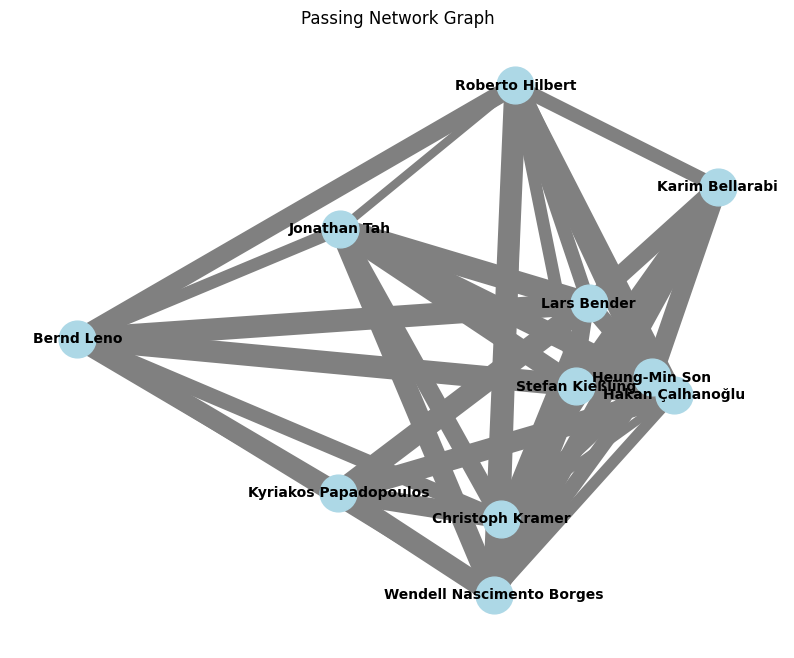

In [11]:
example_game = load_game_data('../data/2015-2016/1-Bundesliga/3890260_Bayer-Leverkusen_1_59.json')

G_example = construct_adjacency_matrix(example_game)
visualize_passing_network(G_example)

In [12]:
def graph_to_adjacency_matrix(G):
    nodes = sorted(G.nodes())
    adj_matrix_noinf = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
    adj_matrix = np.where(adj_matrix_noinf == 0, np.inf, adj_matrix_noinf)
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix, nodes

In [13]:
adj_matrix, nodes = graph_to_adjacency_matrix(G_example)
print("Adjacency Matrix:")
print(adj_matrix)
print("\nNodes Order:")
print(nodes)

Adjacency Matrix:
[[ 0. 11. 16. inf  9. inf 14. 16. 13. 10. 10.]
 [11.  0.  6. 12. 13. 10. 14.  8. 13. inf  1.]
 [16.  6.  0. 12. 15. inf 15. 10. 14.  5.  8.]
 [inf 12. 12.  0. inf 14. inf 13. 16. 13. 11.]
 [ 9. 13. 15. inf  0. inf inf 16.  6. 15. 15.]
 [inf 10. inf 14. inf  0. inf 13. 10. 15. 14.]
 [14. 14. 15. inf inf inf  0. 16. inf inf 15.]
 [16.  8. 10. 13. 16. 13. 16.  0. 10.  8. 11.]
 [13. 13. 14. 16.  6. 10. inf 10.  0.  9. 16.]
 [10. inf  5. 13. 15. 15. inf  8.  9.  0. 14.]
 [10.  1.  8. 11. 15. 14. 15. 11. 16. 14.  0.]]

Nodes Order:
['Bernd Leno', 'Christoph Kramer', 'Hakan Çalhanoğlu', 'Heung-Min Son', 'Jonathan Tah', 'Karim Bellarabi', 'Kyriakos Papadopoulos', 'Lars Bender', 'Roberto Hilbert', 'Stefan Kießling', 'Wendell Nascimento Borges']


In [14]:
vr_persistence = VietorisRipsPersistence(
        metric="precomputed",
        homology_dimensions=[0, 1],  # Compute H0 and H1
        collapse_edges=True  # Handle disconnected graphs
    )

diagrams = vr_persistence.fit_transform([adj_matrix])[0]
plot_diagram(diagrams)